In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

gaia = Table.read('Gaia.vot')

Convert to pandas and inspect

In [2]:
# load the data to the pandas dataframe
import pandas as pd
df = gaia.to_pandas()
df.head()


,ra,dec,parallax,parallax_error,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,l,b
0,235.210639,-75.473087,0.189616,0.024176,-5.310136,-3.329038,12.836737,13.770793,11.897108,0.414605,0.672070,313.058982,-16.046951
1,246.404137,15.035012,3.208649,0.078680,-13.387038,-3.750262,11.661827,11.958838,11.193132,-43.597626,0.758399,30.661481,38.977174
2,294.739961,34.312760,0.351728,0.026255,-0.872637,-6.209009,12.918020,13.580598,12.147714,21.996602,0.671250,68.558197,6.067830
3,269.133379,-13.517191,0.455662,0.032030,-1.647247,-4.513978,13.561970,14.860425,12.432927,-47.240378,0.366152,14.585552,5.667024
4,237.769431,-75.513386,0.795595,0.023005,-15.195014,-16.791597,12.819647,13.383797,12.126850,-86.816011,0.579865,313.545296,-16.487915


Convert to radiant and select on the galactic plane

In [3]:
bMax = 5
df = df.loc[(df['b'] >= -bMax) & (df['b'] <= bMax)]

df['l'] = np.deg2rad(df['l'])



Usefull quantities and constants

In [4]:
# distance from the center of the galaxy
R = 8300

########################################################################
# cos and sin of longitude
df['cosl'] = np.cos(df['l'])
df['sinl'] = np.sin(df['l'])

########################################################################
# distance from the sun
df['d'] = 1000 / df['parallax']

########################################################################
# distance from galactic centre
df['D'] = np.sqrt( df['d']**2 + R**2 - 2*df['d']*R*df['cosl'])

########################################################################
# cos and sin of phi (angle from galactic center)
df['cosphi'] = (df['d'] * df['cosl'] - R) / df['D'] 
df['sinphi'] = (df['d'] * df['sinl']) / df['D']

##########################################################################


Error propagation (from the parallax)

In [5]:
########################################################################
# Parallax to distance
df['sigmad'] = 1000 * df['parallax_error'] / (df['parallax']**2)

########################################################################
# distance to sin and cos phi
# NOTE: sin and cos phi are not independant, and the error of the distance should be propagated all at once

# derivatives wrt distance
df['DER_cosphi'] = R * df['d'] * (df['sinl']**2) / (df['D']**3)
df['DER_sinphi'] = - R * df['cosphi'] * df['sinl'] / (df['D']**2)

# squared derivative of vmodel wrt distance without vrot**2, which is a parameter
df['DER2_Prop_model'] = (df['cosl'] * df['DER_sinphi'] - df['sinl'] * df['DER_cosphi'])**2

# variance associated to radial velocitu
df['VAR_rad_vel'] = df['radial_velocity_error']**2

## Statistical model

In [6]:
def log_like(par, vrad, var_vrad, prop, sinl, cosl, sinphi, cosphi):
    vrot, u, v = par
    return -0.5*( np.sum( (vrad - vrot*( sinphi*cosl - (1 + cosphi)*sinl) - u*cosl - v*sinl)**2 /(var_vrad + (vrot**2)*prop) + np.log(var_vrad + (vrot**2)*prop) ) )

#tipical star motion in galaxies
vgal=200

# interval where the prior is defined and different from 0
Vmin = -500
Vmax = 500

# log prior
def log_prior(par):
    vrot,u,v=par
    if not Vmin<=vrot<=Vmax:
        return -np.inf
    if not Vmin<=u<=Vmax:
        return -np.inf
    if not Vmin<=v<=Vmax:
        return -np.inf

    #return -(0.5*(u**2+v**2)/vgal**2) - np.log(np.abs(vrot)) 
    return -(0.5*(u**2+v**2)/vgal**2)

# log prob
def log_prob(par,vrad,var_vrad,prop,sinl,cosl,sinphi,cosphi):
    lp=log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(par,vrad,var_vrad,prop,sinl,cosl,sinphi,cosphi)


## Walkers to sample space parameter

In [7]:
import emcee

ndim = 3  
nwalkers = 12
nsteps = 10000 
burnin = 100

# Valori iniziali casuali per i walker
p0 = np.random.randn(nwalkers, ndim) 

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(df['radial_velocity'], df['VAR_rad_vel'], df['DER2_Prop_model'], df['sinl'], df['cosl'], df['sinphi'], df['cosphi']))

sampler.run_mcmc(p0, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=burnin, thin=10, flat=True)

print("Forma dei campioni:", flat_samples.shape)

100%|██████████| 10000/10000 [12:10<00:00, 13.68it/s]

Forma dei campioni: (11880, 3)


plot the walkers

Text(0.5, 0, 'step number')

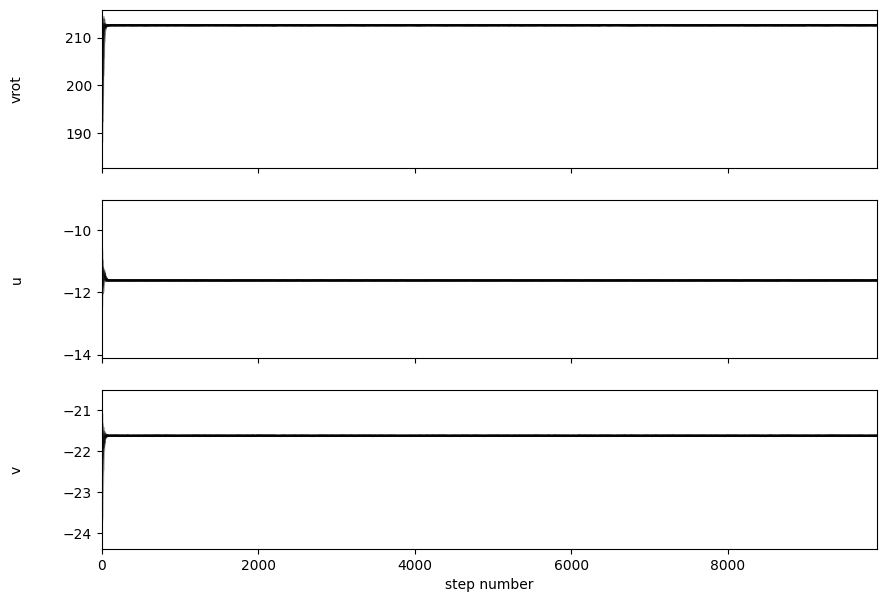

In [8]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
labels = ["vrot", "u", "v"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plot contour

(11880, 3)


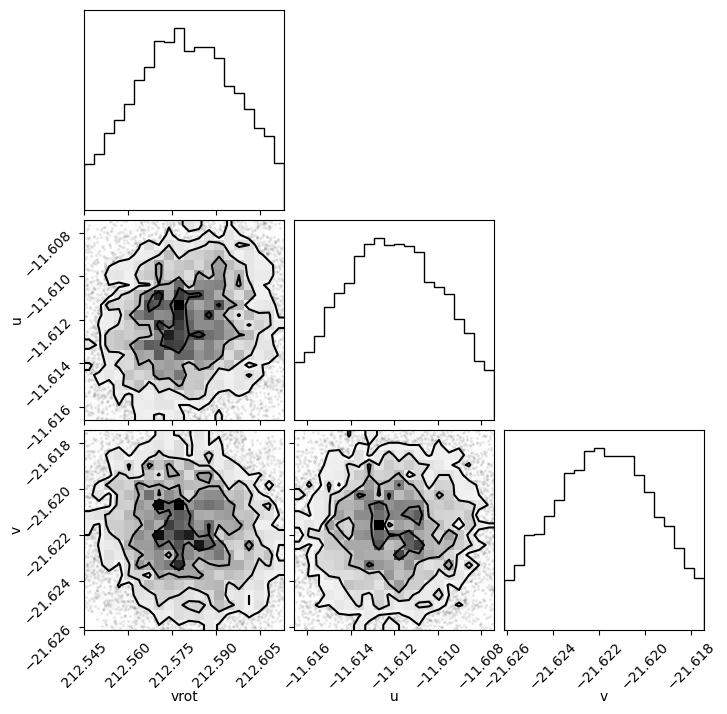

In [9]:
import corner
# Compute the 5th and 95th percentiles for each parameter
ranges = []
for i in range(flat_samples.shape[1]):  # Iterate over dimensions
    lower, upper = np.percentile(flat_samples[:, i], [5, 95])
    ranges.append((lower, upper))

print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels, range=ranges, truths=[220, 10, 10])